In [1]:
# Source: https://github.com/vassagoP/segment-anything/blob/main/notebooks/predictor_example.ipynb
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
# Utils
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

(256, 256, 3)
3


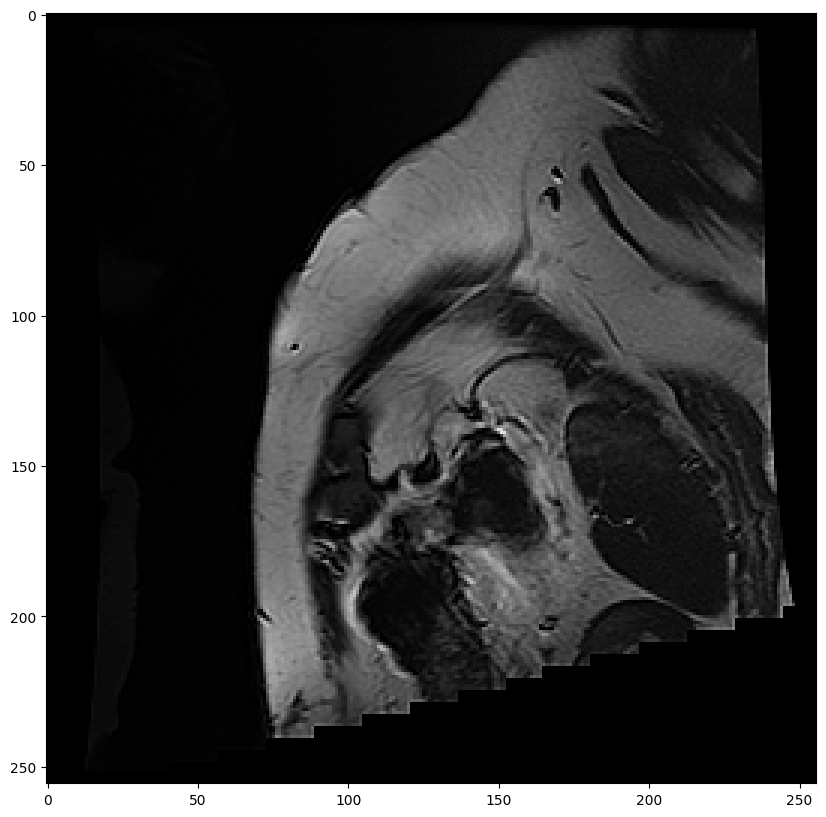

In [22]:
# Read data
import nibabel as nib
import imageio
import os

filepath = './data/averaged-training-images/'
filenames = os.listdir(filepath)
image_nib = nib.load(filepath + filenames[0])
image = image_nib.dataobj
image0 = image[:,:,0]
image0 = np.stack((image0,)*3, axis=-1)

print(image0.shape)
print(image0.ndim)

plt.figure(figsize=(10,10))
plt.imshow(image0, cmap='gray')
plt.axis('on')
plt.show()

In [23]:
# SAM model
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "./checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image0)

/home/vectorzhao/anaconda3/envs/sam/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


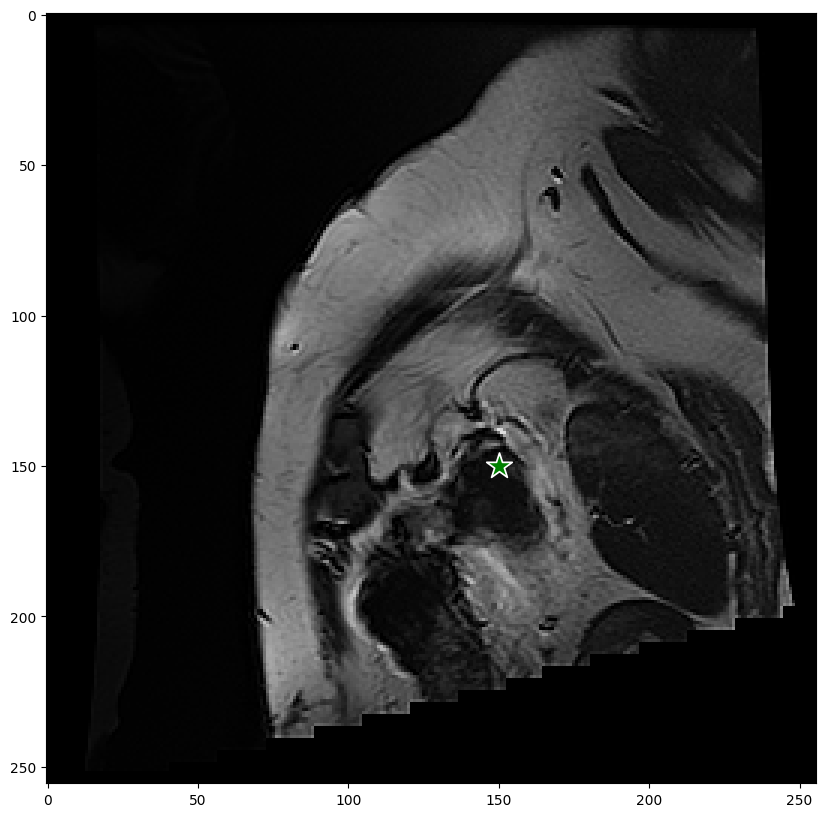

SAM: point mask results


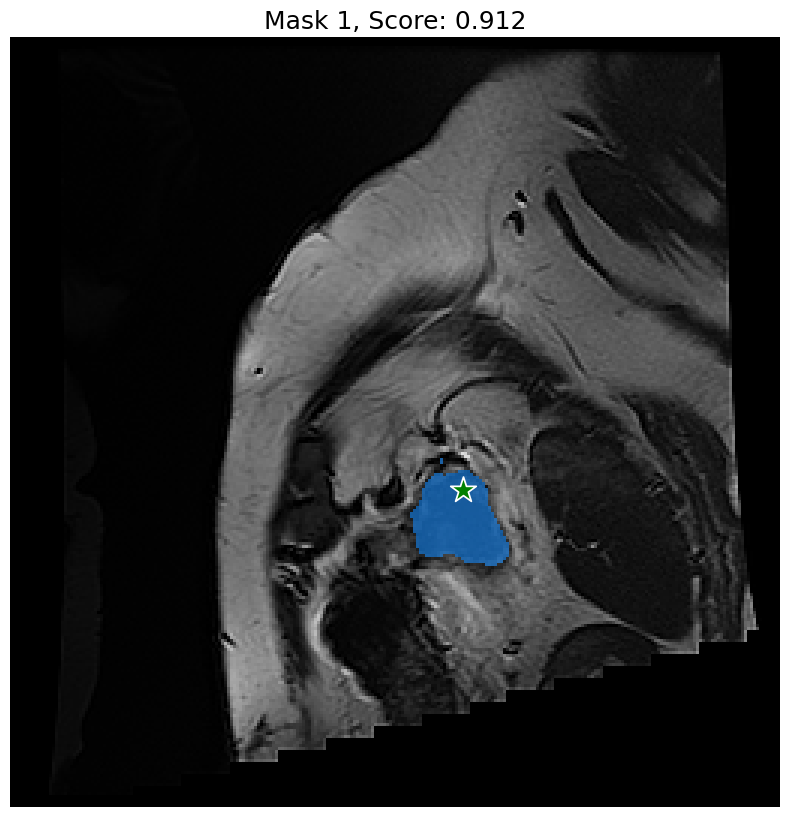

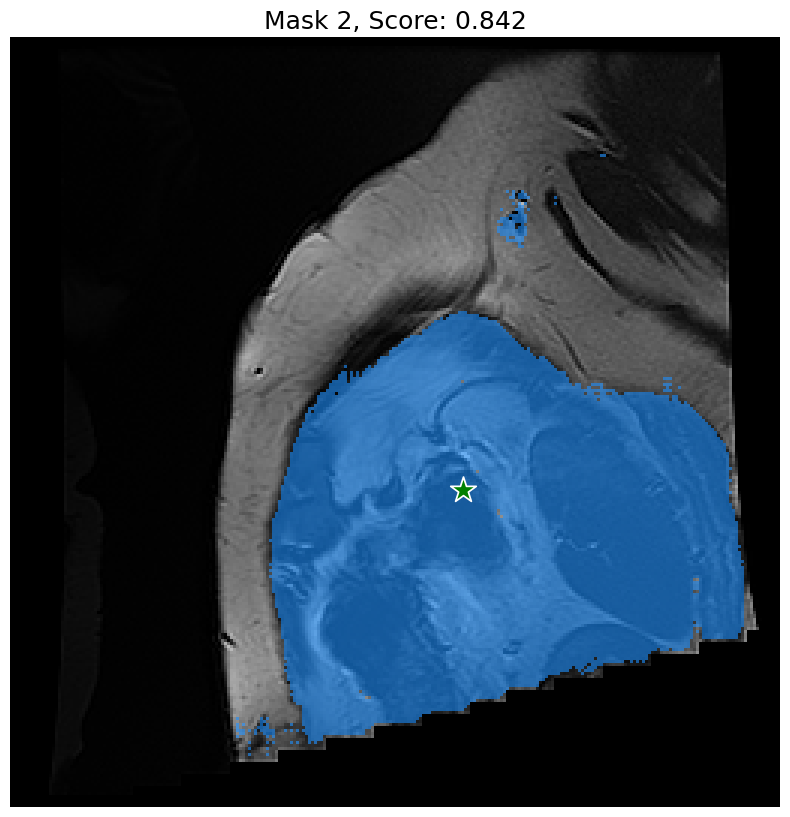

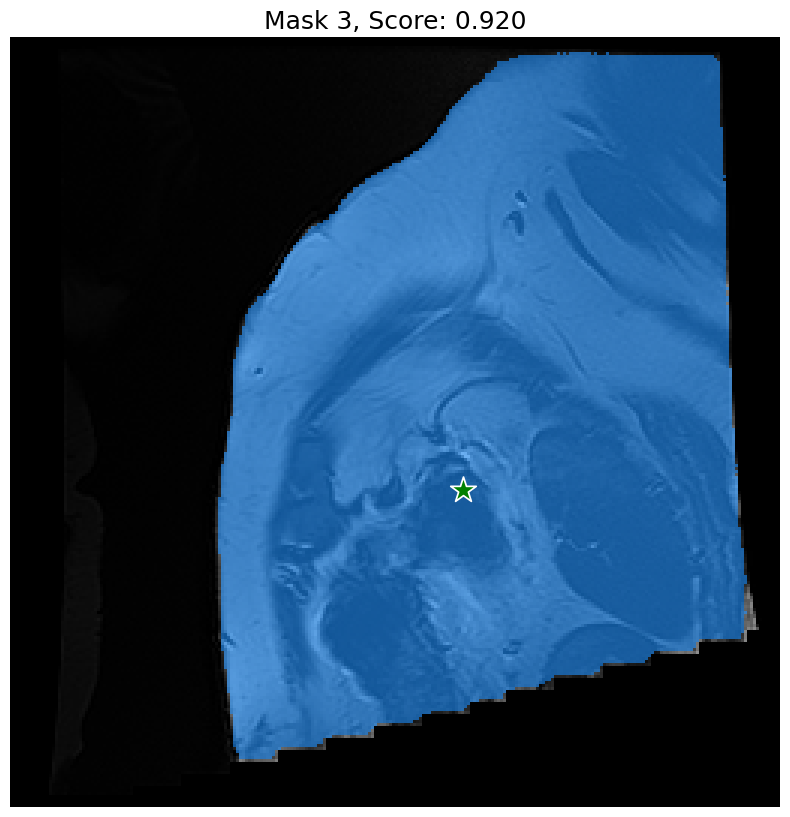

In [28]:
# SAM: point mask
input_point = np.array([[150, 150]])
input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(image0)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

# SAM: point mask results
print("SAM: point mask results")
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image0)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

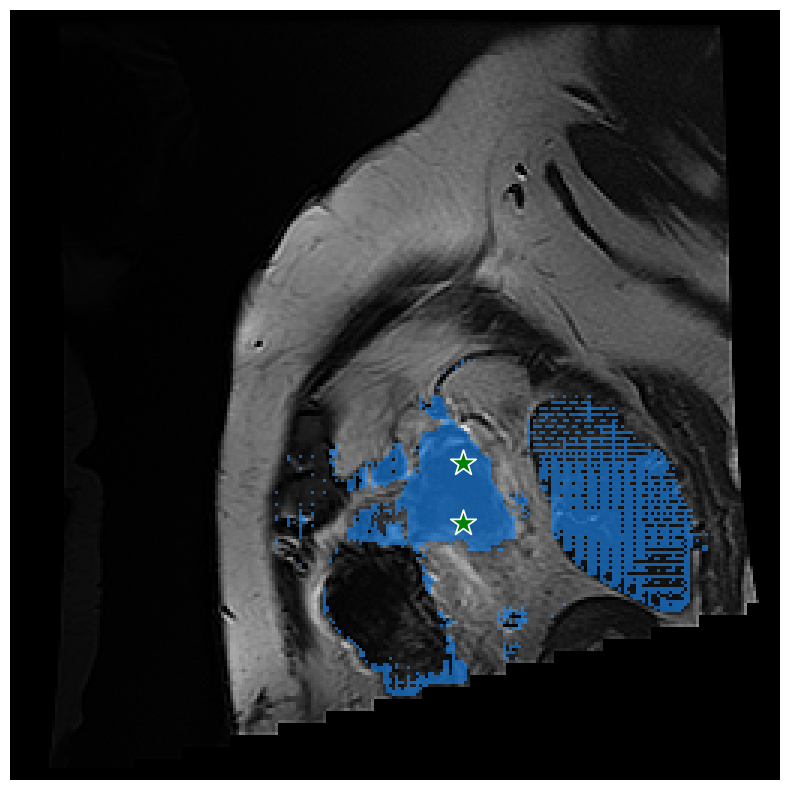

In [29]:
# SAM: multi-point mask
input_point = np.array([[150, 150], [150, 170]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

plt.figure(figsize=(10,10))
plt.imshow(image0)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 
